# How To Analyse Your Time Series Model Using Residuals



## Intro


Being able to analyse your time series model is essential to diagnose its performance. One such way to do this is through the residuals of the fitted model. In this post, we will go over what residuals are and how they can be used to improve your model along with an example in Python.


## What are Residuals?



In time series analysis, residuals, r, are the difference between the fitted values, ŷ, and the actual values, y:

$$
r_i = y_i - \hat{y}_i
$$

It is important to state the difference between residuals and errors. The error is the difference between the actual and forecasted values. However, the residuals, as shown above, are the difference from the actual the fitted values. These fitted values are the predictions the model made to the training data whilst fitting to it. As the model knows the values of all observations, it is no longer technically a forecast but rather a fitted value.

## Residual Analysis



We can use the residuals to analyse how well our model has captured the characteristics of the data. In general, the residuals should:

- Show very little or no autocorrelation or partial autocorrelation. If they have any form of correlation, then the model has missed some information that’s in the data. We can use the Ljung–Box statistical test and a correlogram to determine if the residuals are indeed correlated.
- The mean of the residuals should be zero, otherwise the forecast will be biased. In reality, this is quite easy to adjust for by simply adding or subtracting the bias from the forecasts.

##  In Python

### Fitting a Holt Winters’ Model

For this short walkthrough, we will fit the exponential smoothing Holt Winters’ model to the famous US airline passenger dataset.

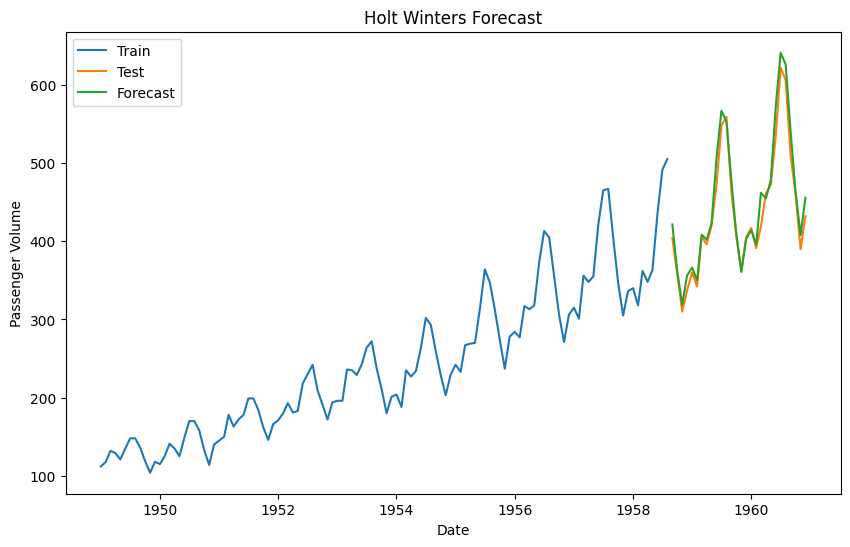

In [3]:
# Import packages
import plotly.graph_objects as go
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import kagglehub
import matplotlib.pyplot as plt

# Read in the data
path = kagglehub.dataset_download("ashfakyeafi/air-passenger-data-for-time-series-analysis")
data = pd.read_csv(path + '/AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]


def plot_func(forecast: list[float],
              title: str) -> None:
    #"""Function to plot the forecasts."""
    #fig = go.Figure()
    #fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    #fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    #fig.add_trace(go.Scatter(x=test['Month'], y=forecast, name='Forecast'))
    #fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
    #                  width=700, title_x=0.5, height=400, xaxis_title='Date',
    #                  yaxis_title='Passenger Volume')

    #return fig.show()

    plt.figure(figsize=(10, 6))
    plt.plot(train['Month'], train['#Passengers'], label='Train')
    plt.plot(test['Month'], test['#Passengers'], label='Test')
    plt.plot(test['Month'], forecast, label='Forecast')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Passenger Volume')
    plt.legend()
    plt.show()



# Fit Holt Winters model and get forecasts
model = ExponentialSmoothing(train['#Passengers'], trend='mul', seasonal='mul', seasonal_periods=12)\
    .fit(optimized=True)
forecasts = model.forecast(len(test))

# Plot the forecasts
plot_func(forecasts,  "Holt Winters Forecast")

The forecast from this model looks pretty good. 

In [6]:
# Appending residuals and fitted values to the train dataframe
train['fittedvalues'] = model.fittedvalues
train['residuals'] = model.resid
print(train)

         Month  #Passengers  fittedvalues  residuals
0   1949-01-01          112    111.999636   0.000364
1   1949-02-01          118    119.391936  -1.391936
2   1949-03-01          132    132.484086  -0.484086
3   1949-04-01          129    126.798559   2.201441
4   1949-05-01          121    118.553055   2.446945
..         ...          ...           ...        ...
111 1958-04-01          348    370.894593 -22.894593
112 1958-05-01          363    370.984374  -7.984374
113 1958-06-01          435    435.713019  -0.713019
114 1958-07-01          491    479.724014  11.275986
115 1958-08-01          505    479.483233  25.516767

[116 rows x 4 columns]


/var/folders/_x/ry3jbs9j2b50yr7wpq6rgkrc0000gn/T/ipykernel_6878/2996281503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['fittedvalues'] = model.fittedvalues
/var/folders/_x/ry3jbs9j2b50yr7wpq6rgkrc0000gn/T/ipykernel_6878/2996281503.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['residuals'] = model.resid


### Residual Correlation

The correlation of the residuals can be computed by plotting their autocorrelation and partial autocorrelation function.

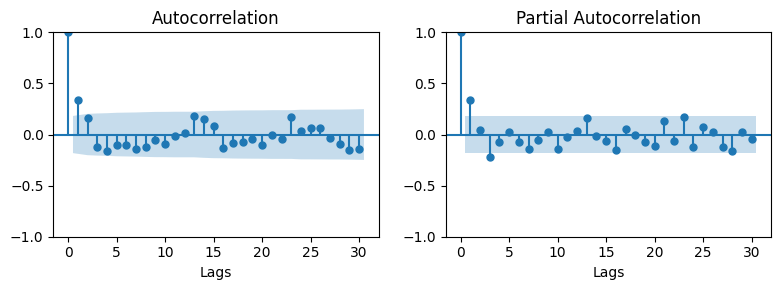

In [7]:
# Import packages
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, ax = plt.subplots(1,2,figsize=(8,3))
plot_acf(train['residuals'], lags=30, ax=ax[0])
ax[0].set_xlabel('Lags')
plot_pacf(train['residuals'], lags=30, ax=ax[1])
ax[1].set_xlabel('Lags')
plt.tight_layout()
plt.show()

Majority of the correlations are within the non-statistically significant blue region, which would signify that the residuals are not correlated. However, you may notice that there is some recurring pattern in the correlations. This would convey that there is some seasonal component that the model may have not fully accounted for.

### Ljung-Box Test


A more quantitive way to determine if the residuals are correlated is to carry out the Ljung–Box statistical test:

H_0: Residuals are independently distributed.

H_1: Residuals are not independently distributed and exhibit serial correlation.

In [8]:
# Import packages
from statsmodels.stats.diagnostic import acorr_ljungbox

# Carry out Ljung-Box test
print(acorr_ljungbox(train['residuals'], return_df=True))


      lb_stat  lb_pvalue
1   13.917248   0.000191
2   16.932092   0.000210
3   18.861079   0.000292
4   22.061221   0.000195
5   23.398206   0.000283
6   24.627471   0.000400
7   27.058908   0.000325
8   29.030736   0.000313
9   29.343855   0.000567
10  30.414623   0.000733


This shows the p-values of the first 10 lags. They are all below the significance level of 0.05, therefore we reject the null hypothesis of no autocorrelation. Thus, there is correlation present in our residuals that we need to revisit when re-fitting the model.

### Histogram of Residuals


A histogram of the residuals will determine if they have a mean of zero and are symmetric (no bias):

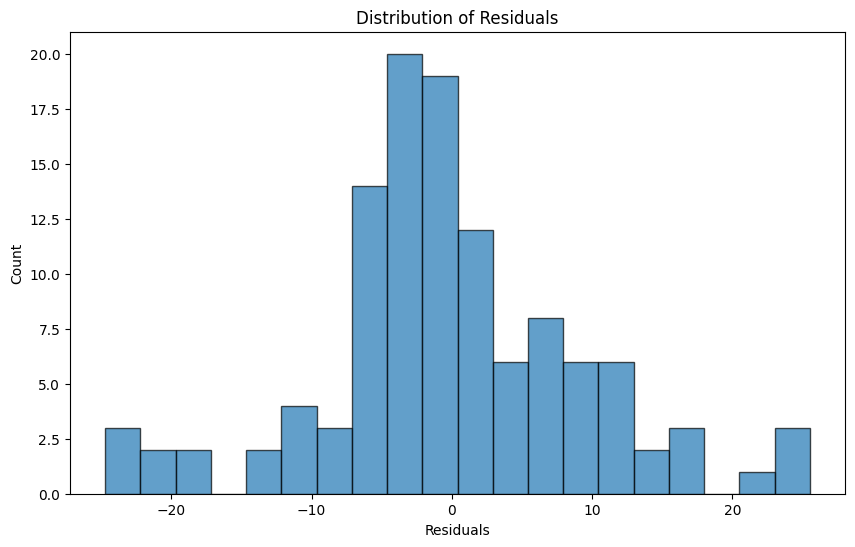

-0.022924134094258176


In [10]:
# Import plotly
import plotly.express as px

# Plot histogram of the residuals using matplotlib

plt.figure(figsize=(10, 6))
plt.hist(train['residuals'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.show()


# Mean of residuals
print(train['residuals'].mean())

In this case the residuals are mostly distributed around zero with a mean of -0.023 and maybe even slightly negatively biased. This suggests that we probably don’t need to provide an offset for the computed forecasts.